In [5]:
import gc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as rxr
from osgeo import gdal
from xarray.ufuncs import logical_or  as xr_or
import yaml
from datetime import datetime
import rasterio 

Selecting Bands:

In [6]:
# Directory with Landsat scene data
landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LC08_L2SR_082071_20211126_tmp_2/LC08_L2SR_082071_20211126/'
#landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LE07_L2SP_086067_20060427_tmp/LE07_L2SP_086067_20060427/'

# Select the QA Pixel Band
qa_band = landsat_folder + 'LC08_L2SR_082071_20211126_20211201_02_T1_QA_PIXEL.tif'
#qa_band = landsat_folder + 'LE07_L2SP_086067_20060427_20200914_02_T1_QA_PIXEL.tif'

Bitmasking functions from dc_Mosaic with slight adjustments:

In [7]:
def unpack_bits(land_cover_endcoding, data_array, cover_type):
    boolean_mask = np.isin(data_array.values, land_cover_endcoding[cover_type])
    return xr.DataArray(boolean_mask.astype(bool),
                        coords=data_array.coords,
                        dims=data_array.dims,
                        name=cover_type + "_mask",
                        attrs=data_array.attrs)

def ls8_oli_unpack_qa(data_array, cover_type):
    land_cover_encoding = dict(
                               clear=[21952, 22208],
                               )
    return unpack_bits(land_cover_encoding, data_array, cover_type)

def ls8_unpack_qa(data_array, cover_type):
    """
    Function from dc_mosaic.py

    notes: 4th bit is cloud; 5th/6th bit are cloud confidence; 7th/8th bit are cloud shadow confidence
    """
    boolean_mask = np.zeros(data_array.shape, dtype=bool)

    data_array = data_array.astype(np.int64)

    if cover_type == 'clear':
        # 6th bit is clear
        boolean_mask |=  ((data_array & 0b0000000001000000) != 0)

    elif cover_type == 'water':
        # 7th bit is water
        boolean_mask |= ((data_array & 0b0000000010000000) != 0)

    else:
        raise ValueError(f"Cover type {cover_type} not supported for Landsat 8 yet")

    #logging.info(f"Applied {cover_type} mask for Landsat 8")
    return xr.DataArray(boolean_mask.astype(bool),
                        coords=data_array.coords,
                        dims=data_array.dims,
                        name=cover_type + "_mask",
                        attrs=data_array.attrs)

def ls7_unpack_qa(data_array, cover_type):
    land_cover_endcoding = dict(fill=[1],
                                clear=[5896],
                                water=[68, 132],
                                shadow=[72, 136],
                                snow=[80, 112, 144, 176],
                                cloud=[96, 112, 160, 176, 224],
                                low_conf=[66, 68, 72, 80, 96, 112],
                                med_conf=[130, 132, 136, 144, 160, 176],
                                high_conf=[224]
                                )
    return unpack_bits(land_cover_endcoding, data_array, cover_type)



def landsat_qa_clean_mask(dataset, platform, cover_types):
    processing_options = {
        #"LANDSAT_4": ls4_unpack_qa,
        #"LANDSAT_5": ls5_unpack_qa,
        "LANDSAT_7": ls7_unpack_qa,
        "LANDSAT_8": ls8_unpack_qa,
        #"SENTINEL_2": sen2_unpack_qa
    }

    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    
    if platform == "SENTINEL_2":
        for i, cover_type in enumerate(cover_types):
            cover_type_clean_mask = processing_options[platform](dataset.scene_classification, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    
    else: 
        
        for i, cover_type in enumerate(cover_types):
            print(f'running cover_type: {cover_type}')
            print(dataset.pixel_qa)
            cover_type_clean_mask = processing_options[platform](dataset.pixel_qa, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)

    return clean_mask

def rename_bands(in_xr, des_bands, position):
    in_xr.name = des_bands[position]
    return in_xr

Prepare data and run bitmasking:

In [8]:
# Read the QA Pixel Band as array
qa_arr = gdal.Open(qa_band).ReadAsArray()

# Get the metdata from qa_band to align the boolean mask to it
with rasterio.open(qa_band) as src:
    profile = src.profile
    crs = src.crs
    transform = src.transform

# Read yml metadata
yml = landsat_folder + 'datacube-metadata.yaml'
with open (yml) as stream: yml_meta = yaml.safe_load(stream) 

# Define desired bands
des_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

# Read bands with xarray
o_bands_data = [ rxr.open_rasterio(landsat_folder + yml_meta['image']['bands'][b]['path']) for b in des_bands ] 
bands_data = xr.merge([rename_bands(bd, des_bands, i) for i,bd in enumerate(o_bands_data)]).rename({'band': 'time'}) # ensure band names & dims consistent
bands_data = bands_data.assign_attrs(o_bands_data[0].attrs) # crs etc. needed later
bands_data['time'] = [datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')] # time dim needed for wofs


In [9]:
clearsky_masks = landsat_qa_clean_mask(bands_data, 'LANDSAT_8', cover_types=['clear', 'water'])
#water_masks = landsat_qa_clean_mask(bands_data, 'LANDSAT_8', cover_types=['water'])

running cover_type: clear
<xarray.DataArray 'pixel_qa' (time: 1, y: 9763, x: 8664)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * x            (x) float64 165.8 165.8 165.8 165.8 ... 167.9 167.9 167.9 167.9
  * y            (y) float64 -16.97 -16.97 -16.97 ... -14.84 -14.84 -14.84
  * time         (time) datetime64[ns] 2021-11-26
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0


/home/spatialdays/anaconda3/envs/SAR/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


running cover_type: water
<xarray.DataArray 'pixel_qa' (time: 1, y: 9763, x: 8664)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])
Coordinates:
  * x            (x) float64 165.8 165.8 165.8 165.8 ... 167.9 167.9 167.9 167.9
  * y            (y) float64 -16.97 -16.97 -16.97 ... -14.84 -14.84 -14.84
  * time         (time) datetime64[ns] 2021-11-26
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    scale_factor:        1.0
    add_offset:          0.0


/home/spatialdays/anaconda3/envs/SAR/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/tmp/ipykernel_1403703/3264901589.py:81: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
/home/spatialdays/anaconda3/envs/SAR/lib/python3.11/site-packages/xarray/core/dataarray.py:3081: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/home/spatialdays/anaconda3/envs/SAR/lib/python3.11/site-packages/xarray/core/variable.py:2409: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


In [10]:
# Write masked data to tif
vis_clearsky_masks = clearsky_masks.squeeze('time').astype('int16')
vis_clearsky_masks.rio.to_raster(raster_path = 'clearsky_mask_vals_l8.tif', driver="COG")

#vis_water_masks = water_masks.squeeze('time').astype('int26')
#vis_water_masks.rio.to_raster(raster_path = 'water_mask.tif', driver="COG")

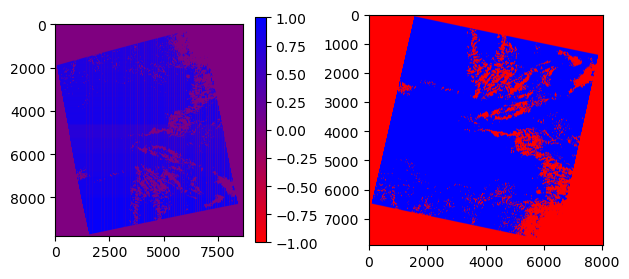

In [11]:
# Visualize masks
# Create the figure and plot the NDWI data
fig, axs = plt.subplots(1, 2)

# Define the custom colormap
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red","blue"])

# Visualize NDWI
clear_im = axs[0].imshow(vis_clearsky_masks, cmap=custom_cmap, vmin=-1, vmax=1)
plt.colorbar(clear_im, ax=axs[0], shrink=0.5)


# QA band with 6th bit flagged 
boolean_mask = np.zeros(qa_arr.shape, dtype=bool)
data_array = qa_arr.astype(np.int64)

boolean_mask |=  ((data_array & 0b0000000001000000) != 0)

# Write the output tif
with rasterio.open('clearsky_mask_vals_l8_boolmask.tif', 'w', **profile) as dst:
    dst.write(boolean_mask.astype(rasterio.uint8), 1)
    dst.crs = crs 
    dst.transform = transform

#boolean_mask.rio.to_raster(raster_path = 'clearsky_mask_vals_l8_boolmask.tif', driver="COG")


# Visualize boolean mask
boolean_im = axs[1].imshow(boolean_mask, cmap=custom_cmap, vmin=0, vmax=1)

plt.tight_layout()

In [ ]:
# Open qa band with gdal
qa = gdal.Open(qa_band)

# Print out crs of qa
print(qa.GetProjection())

# Print out crs of original qa pixel band
print(bands_data['pixel_qa'].rio.crs)

# Print out crs of clearsky mask
print(vis_clearsky_masks.rio.crs)